## Analyzing Torch Profiler data

This notebook serves as a quick walkthrough of analyzing torch profiler data. 

We use [Torch Profiler](https://pytorch.org/docs/stable/profiler.html#torch.profiler.profile) to record training performance metrics. 

Some useful options to note for setting up profiler params are:

*  tracing_schedule = schedule(wait=5, warmup=2, active=2, repeat=1)

    - wait: during wait steps, the profiler is disabled

    - warmup: during warmup, profiler starts tracing but the results are discarded as the overhead in the beginning may lead to skew in the results.

    - active: the number of steps for which the results are being recorded and stored.

    - repeat: only repeats profiling for number of repeat.

* on_trace_ready = tensorboard_trace_handler(
            dir_name=TMP_PROFILER_LOG_DIR_NAME, use_gzip=True
        )
    
    -  on_trace_ready is a callable that stores the profiling results whene `schedule` does `RECORD_AND_SAVE` data, (i.e after `wait + warmup + active`). In our setup we first write result to a tmp local dir. After training is done, the results will be uploaded to the dir defined in GiGL's task_config.yaml. 

You can adjust profiler params in GiGL's task_config.yaml as follows:

```
profilerConfig:
    should_enable_profiler: true
    profiler_log_dir: gs://path_to_my_bucket
    profiler_args:
        wait:'0'
        with_stack: 'True'
```


### Start Analysis
If you specified `profiler_log_dir` to be gs://, first copy the data to your preferred local dir. Then use `gunzip` cmd to decompress `json.gz` files.

There are couple ways to analyze the results: 

1. Tesnorboard [plugin](https://pytorch.org/tutorials/intermediate/tensorboard_profiler_tutorial.html#:~:text=tensorboard%20plugin%20support%20has%20been%20deprecated%2C%20so%20some%20of%20these%20functions%20may%20not%20work%20as%20previously.%20please%20take%20a%20look%20at%20the%20replacement%2C%20hta.)
. However, this tends to be unstable and being deprecated.

2. We use [HolisticTraceAnalysis](https://hta.readthedocs.io/en/latest/source/intro/using_hta.html) to visualize profiler results, which comes with useful ipynb tutorials too.

The example below, uses gat trainer configs with these configs:

```
trainerArgs:
    conv_dropout: '0.5'
    early_stop_criterion: loss
    early_stop_patience: '10'
    gnn_model: GAT
    heads: '1'
    hid_dim: '256'
    loss_function: retrieval
    main_sample_batch_size: '2048'
    num_layers: '2'
    num_test_batches: '100'
    num_val_batches: '100'
    optim_lr: '0.005'
    optim_weight_decay: '0.0005'
    out_dim: '128'
    random_negative_sample_batch_size: '512'
    random_negative_sample_batch_size_for_evaluation: '1000'
    should_l2_normalize_output: 'True'
    softmax_temperature: '0.01'
    test_main_sample_num_workers: '2'
    test_random_sample_num_workers: '1'
    train_main_sample_num_workers: '4'
    train_random_sample_num_workers: '2'
    val_every_num_batches: '100'
    val_main_sample_num_workers: '2'
    val_random_sample_num_workers: '1'
```

The profiler data is stored in `gs://my-bucket/torch_profiler/gat`

You can copy that to a local dir `/path/to/trace/directory`, to run this example for yourself.

In [1]:
from hta.trace_analysis import TraceAnalysis

trace_path = "/path/to/trace/directory"
analyzer = TraceAnalysis(trace_dir = trace_path)
# below we can see 8 trace files, since in this example we had 8 machines where 1 GPU was attached to each one of them.

2023-12-01 17:12:17,573 - hta - trace.py:L389 - INFO - /home/eghazizadeh/profiler/log/default/profiler
2023-12-01 17:12:17,574 - hta - trace_file.py:L94 - INFO - Rank to trace file map:
{6: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool1-c3d0163b37-5-qvwt7_1.1700681745062.pt.trace.json', 0: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool0-c3d0163b37-0-vnv77_1.1700681762056.pt.trace.json', 5: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool1-c3d0163b37-4-xgxkl_1.1700681745753.pt.trace.json', 4: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool1-c3d0163b37-3-p6xx6_1.1700681740043.pt.trace.json', 7: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool1-c3d0163b37-6-5wkbh_1.1700681751044.pt.trace.json', 1: '/home/eghazizadeh/profiler/log/default/profiler/cmle-training-workerpool1-c3d0163b37-0-gmd8s_1.1700681742992.pt.trace.json', 3: '/home/eghazizadeh/profiler/log/defa

In [9]:
import plotly.io as pio
pio.renderers.default = "svg"

To best utilize the GPUs it is vital to understand where the GPU is spending time for a given job. Is the GPU spending time on computation, communication, memory events, or is it idle? The temporal breakdown feature breaks down the time spent in three categories

Idle time - GPU is idle.

Compute time - GPU is being used for matrix multiplications or vector operations.

Non-compute time - GPU is being used for communication or memory events.

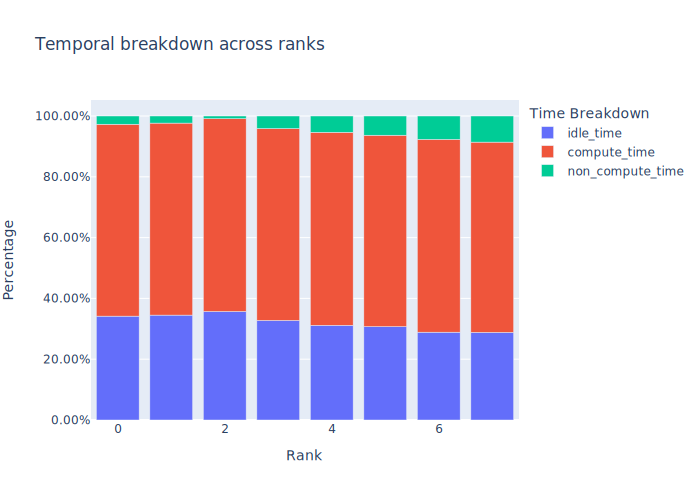

,rank,idle_time(us),compute_time(us),non_compute_time(us),kernel_time(us),idle_time_pctg,compute_time_pctg,non_compute_time_pctg
0,0,10842530,20034382,859006,31735918,34.16,63.13,2.71
1,1,10940116,20026466,740287,31706869,34.50,63.16,2.33
2,2,11295398,20078769,277917,31652084,35.69,63.44,0.88
3,3,10371554,19982170,1309479,31663203,32.76,63.11,4.14
4,4,9887948,20153153,1699576,31740677,31.15,63.49,5.35
5,5,9756574,19996446,2008255,31761275,30.72,62.96,6.32
6,6,9174326,20144012,2442956,31761294,28.89,63.42,7.69
7,7,9138860,19841814,2725672,31706346,28.82,62.58,8.60


In [2]:

analyzer.get_temporal_breakdown(visualize=True)

Understanding how much time the GPU is idle and its causes can help direct optimization strategies. A GPU is considered idle when no kernel is running on it. We developed an algorithm to categorize the Idle time into 3 categories:

Host wait: is the idle duration on the GPU due to the CPU not enqueuing kernels fast enough to keep the GPU busy. These kinds of inefficiencies can be resolved by examining the CPU operators that are contributing to the slow down, increasing the batch size and applying operator fusion.

Kernel wait: constitutes the short overhead to launch consecutive kernels on the GPU. The idle time attributed to this category can be minimized by using CUDA Graph optimizations.

Other wait: Lastly, this category includes idle we could not currently attribute due to insufficient information. The likely causes include synchronization among CUDA streams using CUDA events and delays in launching kernels.

2023-12-01 17:15:47,457 - hta - breakdown_analysis.py:L433 - INFO - Processing stream 7
2023-12-01 17:15:47,503 - hta - breakdown_analysis.py:L473 - INFO - Computing descriptive statistics for idle time intervals on stream 7:
2023-12-01 17:15:47,531 - hta - breakdown_analysis.py:L433 - INFO - Processing stream 13
2023-12-01 17:15:47,536 - hta - breakdown_analysis.py:L473 - INFO - Computing descriptive statistics for idle time intervals on stream 13:


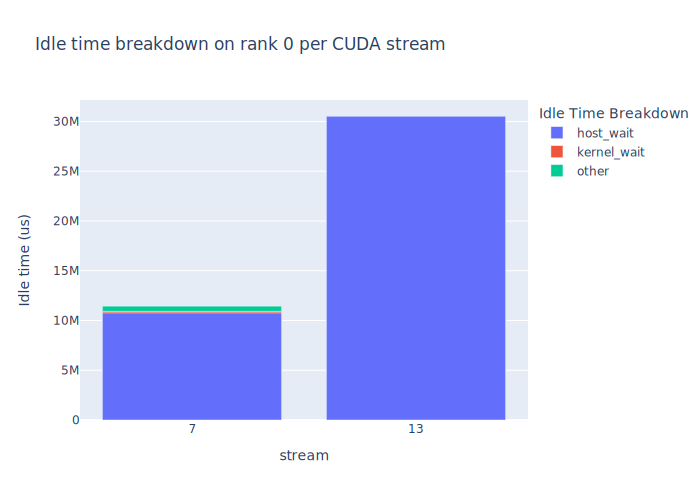

(   rank stream idle_category   idle_time  idle_time_ratio
 0     0      7     host_wait  10762915.0             0.94
 1     0      7   kernel_wait    172818.0             0.02
 2     0      7         other    506475.0             0.04
 3     0     13     host_wait  30546559.0             1.00
 4     0     13   kernel_wait        15.0             0.00
 5     0     13         other         0.0             0.00,
                rank  stream     count        mean          std    min     25%  \
 idle_category                                                                   
 host_wait         0       7  165254.0       65.13       899.47    9.0   34.00   
 kernel_wait       0       7   97170.0        1.78         1.90    0.0    1.00   
 other             0       7      13.0    38959.62    140321.26   31.0   33.00   
 host_wait         0      13       4.0  7636639.75  15248867.12  397.0  587.50   
 kernel_wait       0      13       2.0        7.50         7.78    2.0    4.75   
 other      

In [3]:
# analyzer.get_idle_time_breakdown(ranks=[0,1,2,3,4,5,6,7])
analyzer.get_idle_time_breakdown(show_idle_interval_stats=True, visualize_pctg=False)

In distributed training a significant amount of time is spent in communication and synchronization events between GPUs. To achieve high GPU efficiency (i.e. TFLOPS/GPU) it is vital to keep the GPU oversubscribed with computation kernels. In other words, the GPU should not be blocked due to unresolved data dependencies. One way to measure the extent to which computation is blocked by data dependencies is to calculate the communication computation overlap. Higher GPU efficiency is observed if communication events overlap computation events. Lack of communication and computation overlap will lead to the GPU being idle, thus the efficiency would be low. To sum up, higher communication computation overlap is desirable. To calculate the overlap percentage for each rank we measure the following ratio:

(time spent in computation while communicating) / (time spent in communication

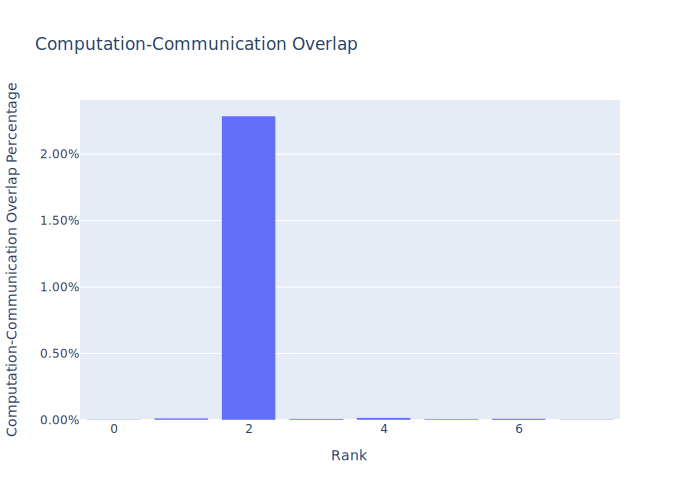

In [12]:
overlap_df = analyzer.get_comm_comp_overlap()

In [6]:
overlap_df

,rank,comp_comm_overlap_pctg
0,0,0.00
1,1,0.01
2,2,2.29
3,3,0.01
4,4,0.02
5,5,0.01
6,6,0.01
7,7,0.01


This feature computes the duration of the CPU runtime event, its corresponding GPU kernel and the launch delay i.e. the difference between GPU kernel starting and CPU operator ending

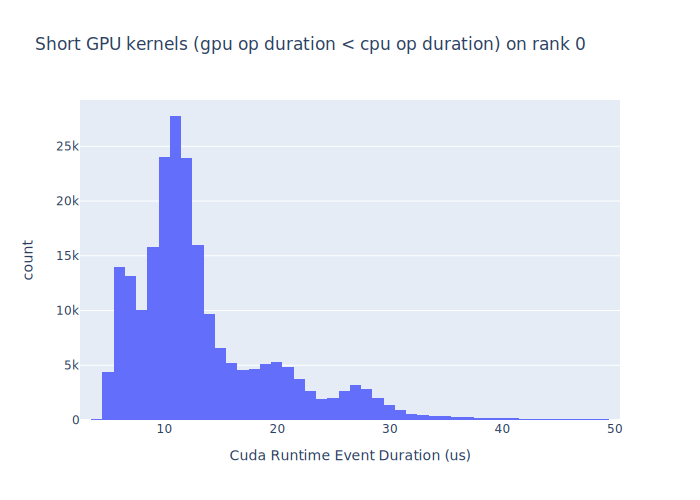

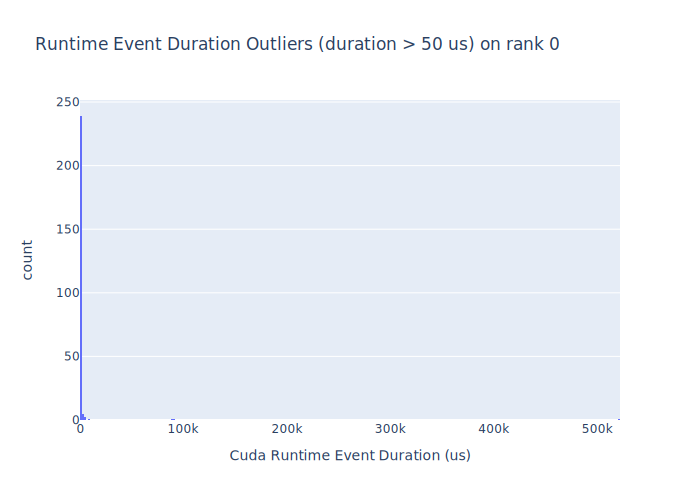

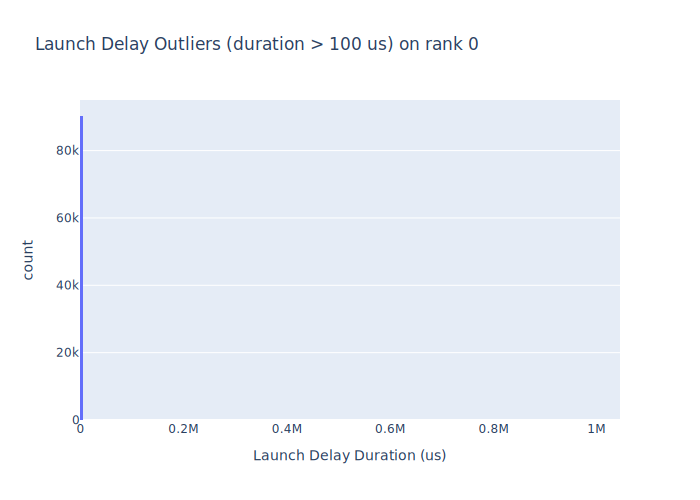

In [13]:
kernel_info_df = analyzer.get_cuda_kernel_launch_stats()


The kernel breakdown feature breaks down the time spent for each kernel type i.e. communication (COMM), computation (COMP), and memory (MEM) across all ranks and presents the proportion of time spent in each category. The percentage of time spent in each category as a pie chart.

In [16]:
analyzer.get_gpu_kernel_breakdown(visualize=False)
# the img from this function cannot be rendered as svg, due the func definition on HTA

(                             kernel_type        sum  percentage
 0                            COMPUTATION  160256062        93.0
 1                          COMMUNICATION    9959549         5.8
 2                                 MEMORY    2103599         1.2
 3  COMPUTATION overlapping COMMUNICATION       1150         0.0
 4         COMPUTATION overlapping MEMORY          0         0.0,
                                                   name  sum (us)  max (us)  \
 0    ncclKernel_AllReduce_RING_LL_Sum_float(ncclWor...    505970    505970   
 1    ncclKernel_AllReduce_RING_LL_Sum_float(ncclWor...    377436    377436   
 2    ncclKernel_AllReduce_RING_LL_Sum_float(ncclWor...      3990      3990   
 3    ncclKernel_AllReduce_RING_LL_Sum_float(ncclWor...   1024913   1024913   
 4    ncclKernel_AllReduce_RING_LL_Sum_float(ncclWor...   1351459   1351459   
 ..                                                 ...       ...       ...   
 131                                    Memset (Device) 